In [1]:
#import libraries
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,label_binarize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle


In [2]:
# Load datasets
csv_file_path1 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/all-data.csv"
csv_file_path2 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/RoBERTaWeaklyLabelling.csv"

try:
    df1 = pd.read_csv(csv_file_path1, encoding='utf-8')
except UnicodeDecodeError:
    df1 = pd.read_csv(csv_file_path1, encoding='latin1')

try:
    df2 = pd.read_csv(csv_file_path2, encoding='utf-8')
except UnicodeDecodeError:
    df2 = pd.read_csv(csv_file_path2, encoding='latin1')

# Concatenate datasets
df = pd.concat([df1, df2], ignore_index=True)
# Data Preprocessing
stop_words = set(stopwords.words('english'))

In [3]:
#preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

df['text'] = df['news'].apply(preprocess_text)
df['label'] = df['label'].apply(lambda x: x.lower())

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [4]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [5]:
# Word2Vec embeddings
sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_matrix = np.zeros((len(word2vec_model.wv), word2vec_model.vector_size))
for i in range(len(word2vec_model.wv)):
    embedding_vector = word2vec_model.wv[word2vec_model.wv.index_to_key[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [6]:
# Define custom dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, word2vec_model):
        self.texts = texts
        self.labels = labels
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        tokens = text.split()
        vec = np.zeros(self.word2vec_model.vector_size)
        for token in tokens:
            if token in self.word2vec_model.wv:
                vec += self.word2vec_model.wv[token]
        return torch.tensor(vec, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


# Create datasets and dataloaders
train_dataset = TextDataset(X_train, y_train, word2vec_model)
test_dataset = TextDataset(X_test, y_test, word2vec_model)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Define FeedForwardNN model
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, activation_function, dropout):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        self.dropout = nn.Dropout(dropout)
        self.activation_function = activation_function
        self.fc2 = nn.Linear(hidden_dims[-1], 3)  # 3 classes for sentiment analysis
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation_function(x)
            x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Model parameters
input_dim = embedding_matrix.shape[1]
hidden_dims = [300, 200,100]
dropout = 0.4 #dropout rate
activation_function = nn.Tanh() #activation function
lr = 0.001 #learning rate

# Initialize model, loss function, and optimizer
model = FeedForwardNN(input_dim, hidden_dims, activation_function, dropout)
criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.Adam(model.parameters(), lr=lr) #optimzer

In [8]:
# Training loop
num_epochs = 13
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/13], Loss: 0.9269
Epoch [2/13], Loss: 0.9313
Epoch [3/13], Loss: 1.0214
Epoch [4/13], Loss: 0.9279
Epoch [5/13], Loss: 0.8486
Epoch [6/13], Loss: 0.8786
Epoch [7/13], Loss: 0.8683
Epoch [8/13], Loss: 0.9528
Epoch [9/13], Loss: 1.0062
Epoch [10/13], Loss: 0.9280
Epoch [11/13], Loss: 0.9515
Epoch [12/13], Loss: 1.0370
Epoch [13/13], Loss: 0.8375


In [9]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = outputs.cpu().numpy()  # Get predicted probabilities
        preds = np.argmax(probs, axis=1)  # Get predicted class labels
        
        all_probs.extend(probs)  
        all_preds.extend(preds)  
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Accuracy: 0.6051
Precision: 0.5994
Recall: 0.6051
F1 Score: 0.5940
              precision    recall  f1-score   support

    negative       0.53      0.34      0.41      3420
     neutral       0.63      0.59      0.61      5386
    positive       0.61      0.75      0.67      6626

    accuracy                           0.61     15432
   macro avg       0.59      0.56      0.57     15432
weighted avg       0.60      0.61      0.59     15432



The model performs best in identifying the positive class, with a recall of 0.75 and an F1-score of 0.67, indicating it is good at identifying positive instances but has a moderate rate of false positives.

The neutral class has a balanced precision and recall, leading to an F1-score of 0.61, showing moderate performance in identifying neutral instances.

The negative class has the lowest performance, with a recall of 0.34 and an F1-score of 0.41, indicating difficulties in correctly identifying negative instances.

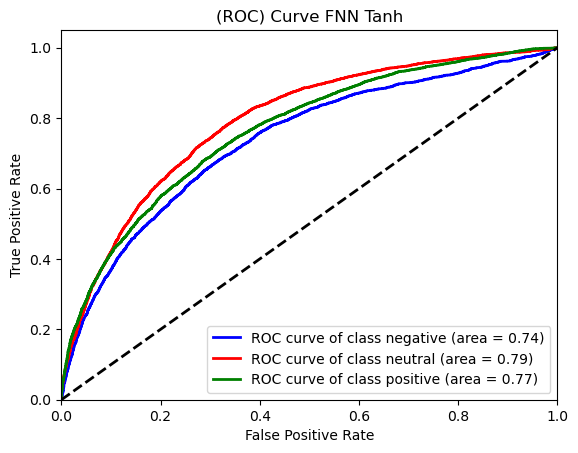

In [10]:
# Binarize the labels for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score_bin = np.array(all_probs)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve FNN Tanh')
plt.legend(loc="lower right")
plt.show()

The ROC curve indicates that it struggles in comparison to more advanced models. The curve is not as close to the top-left corner, suggesting that further tuning or additional layers might be needed to improve their classification power.